### **1. Configuración del Entorno**
#### Instalar las librerías necesarias para el proyecto

In [3]:
!pip install osmnx
!pip install networkx
!pip install matplotlib
!pip install pandas


### 2. Descargar las Ubicaciones y Líneas de Dirección
#### Utilizamos la librería [`osmnx`](https://osmnx.readthedocs.io/en/stable/) para descargar las ubicaciones y líneas de dirección desde [`OpenStreetMap`](https://www.openstreetmap.org/) para el distrito de Miraflores:

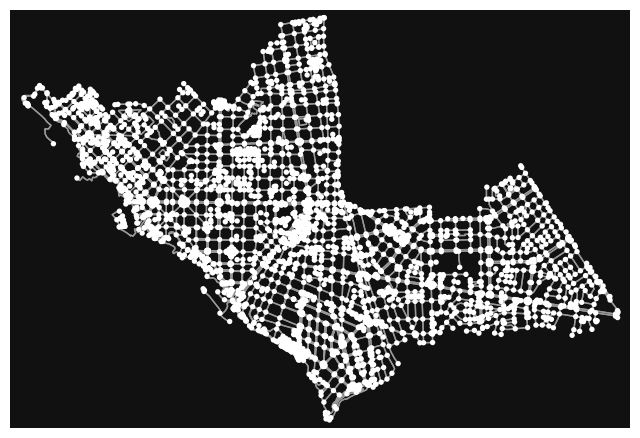

In [11]:
import osmnx as ox
import matplotlib.pyplot as plt

# Definir el lugar y descargar el gráfico de red
place_name = "Miraflores, Lima, Peru"
G = ox.graph_from_place(place_name, network_type='walk')

# Convertir los nodos y aristas a GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Visualizar el gráfico de red
fig, ax = ox.plot_graph(G, show=False, close=False)
plt.show()


### 3. Preprocesamiento del grafo
#### En esta parte se realizará una limpieza del grafo eliminando los nodos no relevantes y rutas ciegas

##### Celda 3.1: Convertir los nodos y bordes a DataFrames


In [12]:
import networkx as nx

# Convertir los nodos y bordes a DataFrames
nodos, bordes = ox.graph_to_gdfs(G)

# Mostrar el número de nodos y bordes antes del preprocesamiento
nodosAntes = len(nodos)
bordesAntes = len(bordes)

print(f"Número de nodos antes del preprocesamiento: {nodosAntes}")
print(f"Número de bordes antes del preprocesamiento: {bordesAntes}")


Número de nodos antes del preprocesamiento: 3408
Número de bordes antes del preprocesamiento: 10406


##### Celda 3.2: Convertir el grafo dirigido a no dirigido


In [13]:
# Convertir el grafo dirigido a no dirigido
G_no_dirigido = G.to_undirected()

##### Celda 3.3: Eliminar nodos aislados

In [14]:
# Eliminar nodos aislados
nodosAislados = list(nx.isolates(G_no_dirigido))
G_no_dirigido.remove_nodes_from(nodosAislados)

print(f"Número de nodos aislados eliminados: {len(nodosAislados)}")

Número de nodos aislados eliminados: 0


##### Celda 3.4: Eliminar componentes conectados no relevantes

In [15]:
# Eliminar componentes conectados no relevantes
componente = max(nx.connected_components(G_no_dirigido), key=len)
G_no_dirigido = G_no_dirigido.subgraph(componente).copy()

print(f"Número de componentes conectados no relevantes eliminados")

Número de componentes conectados no relevantes eliminados


##### Celda 3.5: Eliminar rutas ciegas

In [16]:
# Función para eliminar rutas ciegas
def eliminar_rutas_ciegas(G):
    nodos_con_un_vecino = [n for n, grado in dict(G.degree()).items() if grado == 1]
    while nodos_con_un_vecino:
        G.remove_nodes_from(nodos_con_un_vecino)
        nodos_con_un_vecino = [n for n, grado in dict(G.degree()).items() if grado == 1]
    return G

# Eliminar rutas ciegas
G_no_dirigido = eliminar_rutas_ciegas(G_no_dirigido)

# Mostrar el número de nodos y bordes después del preprocesamiento
nodosDespues = G_no_dirigido.number_of_nodes()
bordesDespues = G_no_dirigido.number_of_edges()

print(f"Número de nodos después del preprocesamiento: {nodosDespues}")
print(f"Número de bordes después del preprocesamiento: {bordesDespues}")

Número de nodos después del preprocesamiento: 2979
Número de bordes después del preprocesamiento: 4795


##### Celda 3.6: Visualizar el grafo procesado

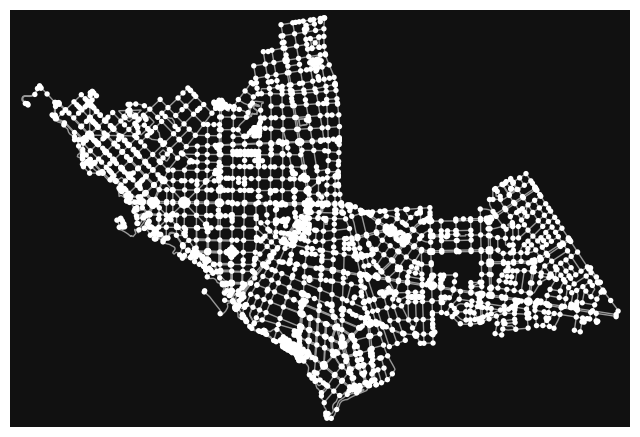

In [17]:
# Gráfico de red procesado
fig, ax = ox.plot_graph(G_no_dirigido, show=False, close=False)
plt.show()

### 4. Almacenar los lugares de interés
#### A continuación, seleccionamos los puntos con características de iglesia (`'place_of_worship', 'christian'`) ⛪

##### Celda 4.1: Descargar puntos de interés

In [18]:
# Almacenar lugares de interés
tags = {'amenity': 'place_of_worship', 'religion': 'christian'}
points = ox.features_from_place(place_name, tags)

#### Celda 4.2: Convertir polígonos a puntos

In [19]:
# Convertir polígonos a puntos usando el centroide
points['geometry'] = points['geometry'].apply(
    lambda geom: geom.centroid if geom.geom_type in ['Polygon', 'MultiPolygon'] else geom)

##### Celda 4.3: Filtrar los nodos de las iglesias

In [20]:
# Lista de nodos correspondientes a iglesias
iglesias_nodos = ox.distance.nearest_nodes(G, points.geometry.x, points.geometry.y)

# Filtrar los nodos de las iglesias para incluir solo aquellos presentes en el grafo preprocesado
iglesias_nodos = [nodo for nodo in iglesias_nodos if nodo in G_no_dirigido.nodes]

##### Celda 4.4: Visualizar las iglesias en el gráfico de red

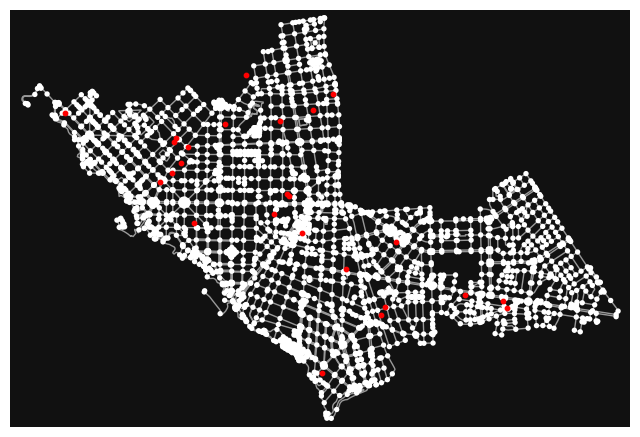

In [21]:
# Visualizar las iglesias en el gráfico de red
fig, ax = ox.plot_graph(G_no_dirigido, show=False, close=False)
points.plot(ax=ax, color='red', markersize=10)
plt.show()

### 5. Distancias entre nodos
#### Aquí se calculan las distancias entre los nodos y se presentan como característica de un borde

##### Celda 5.1: Calcular distancias entre nodos de interés

In [22]:
from itertools import combinations

# Calcular distancias entre todos los pares de nodos de interés
distancias = {}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        distancias[(u, v)] = length
    except nx.NetworkXNoPath:
        continue

##### Celda 5.2: Mostrar algunas de las distancias calculadas


In [23]:
# Mostrar algunas de las distancias calculadas
print("Primeras 10 distancias:")
for i, ((u, v), dist) in enumerate(list(distancias.items())[:10]):
    print(f"{i+1}. Distancia entre {u} y {v}: {dist:.2f} metros")
print("\nÚltimas 10 distancias:")
for i, ((u, v), dist) in enumerate(list(distancias.items())[-10:]):
    print(f"{len(distancias) - 9 + i}. Distancia entre {u} y {v}: {dist:.2f} metros")

Primeras 10 distancias:
1. Distancia entre 263636652 y 4332504766: 3215.60 metros
2. Distancia entre 263636652 y 4266659697: 3115.59 metros
3. Distancia entre 263636652 y 108237811: 3105.76 metros
4. Distancia entre 263636652 y 138851464: 2272.06 metros
5. Distancia entre 263636652 y 6122446208: 1755.32 metros
6. Distancia entre 263636652 y 263617506: 812.68 metros
7. Distancia entre 263636652 y 10800984803: 2868.97 metros
8. Distancia entre 263636652 y 262725526: 4087.69 metros
9. Distancia entre 263636652 y 262571000: 2985.43 metros
10. Distancia entre 263636652 y 114615160: 1123.12 metros

Últimas 10 distancias:
198. Distancia entre 6083786756 y 138854739: 2867.34 metros
199. Distancia entre 6083786756 y 262578746: 3967.11 metros
200. Distancia entre 262572744 y 386837776: 1787.94 metros
201. Distancia entre 262572744 y 4332504766: 1857.15 metros
202. Distancia entre 262572744 y 138854739: 1395.51 metros
203. Distancia entre 262572744 y 262578746: 2110.02 metros
204. Distancia entre

### 6. Estadísticas del problema
#### Cálculo y presentación de estadísticas de interés solicitadas

##### Celda 6.1: Histograma del grado de cada ubicación

In [24]:
import pandas as pd

# Histograma del grado de cada ubicación
degree_hist = pd.Series(dict(G_no_dirigido.degree())).value_counts().sort_index()

##### Celda 6.2: Mostrar estadísticas generales del grafo

In [25]:
# Mostrar estadísticas
print(f"Número de ubicaciones: {nodosDespues}")
print(f"Número de bordes: {bordesDespues}")

radio = nx.radius(G_no_dirigido)
diametro = nx.diameter(G_no_dirigido)
print(f"Radio del grafo: {radio}")
print(f"Diámetro del grafo: {diametro}")

Número de ubicaciones: 2979
Número de bordes: 4795
Radio del grafo: 50
Diámetro del grafo: 99


##### Celda 6.3: Visualizar histograma del grado

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


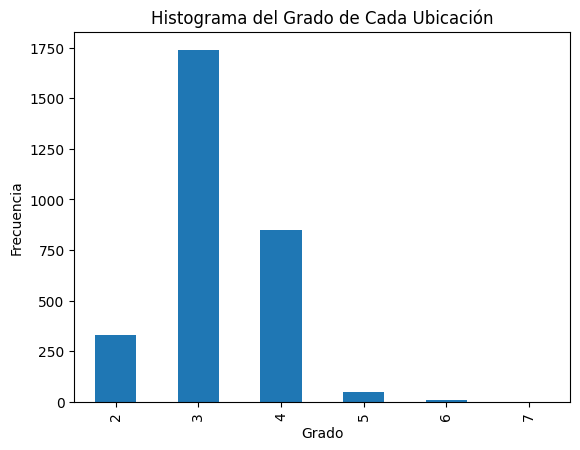

In [26]:
degree_hist.plot(kind='bar')
plt.title('Histograma del Grado de Cada Ubicación')
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.show()

### 7. Estimación de ruta más corta
#### Se aplica el método del vecino más cercano para que un feligrés recorra por todas las iglesias

##### Celda 7.1: Definir función para encontrar el nodo más cercano

In [27]:
def encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia):
    min_dist = float('inf')
    nodo_mas_cercano = None
    for nodo in nodos_restantes:
        if nodo in lista_adyacencia[nodo_actual]:
            dist = lista_adyacencia[nodo_actual][nodo]
            if dist < min_dist:
                min_dist = dist
                nodo_mas_cercano = nodo
    return nodo_mas_cercano, min_dist

##### Celda 7.2: Crear lista de adyacencia

In [28]:
# Crear lista de adyacencia
lista_adyacencia = {nodo: {} for nodo in iglesias_nodos}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G, u, v, weight='length')
        lista_adyacencia[u][v] = length
        lista_adyacencia[v][u] = length
    except nx.NetworkXNoPath:
        continue

##### Celda 7.3: Inicializar variables para el recorrido

In [29]:
# Nodo inicial (puede ser cualquier nodo de inicio, aquí se toma el primero)
nodo_inicial = iglesias_nodos[0]

# Inicializar variables para el recorrido
nodo_actual = nodo_inicial
nodos_restantes = set(iglesias_nodos)
nodos_restantes.remove(nodo_actual)
ruta = [nodo_actual]
distancia_total = 0


##### Celda 7.4: Recorrer todas las iglesias usando el método del vecino más cercano

In [30]:
# Recorrer todas las iglesias usando el método del vecino más cercano
while nodos_restantes:
    nodo_mas_cercano, min_dist = encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia)
    if nodo_mas_cercano is None:
        break
    ruta.append(nodo_mas_cercano)
    distancia_total += min_dist
    nodo_actual = nodo_mas_cercano
    nodos_restantes.remove(nodo_actual)

# Regresar al nodo inicial para completar el ciclo
if nodo_inicial in lista_adyacencia[nodo_actual]:
    distancia_total += lista_adyacencia[nodo_actual][nodo_inicial]
ruta.append(nodo_inicial)

##### Celda 7.5: Mostrar la ruta y la distancia total

In [31]:
# Mostrar la ruta y la distancia total
print("Ruta del feligrés:", ruta)
print(f"Distancia total recorrida: {distancia_total:.2f} metros")

Ruta del feligrés: [263636652, 1760085377, 386837776, 263617506, 6083786756, 114615160, 6122446208, 138854739, 257946723, 138851464, 262572744, 262570611, 262571000, 4266659697, 4332504766, 108237811, 262578746, 10800984803, 197660043, 262725526, 263636652]
Distancia total recorrida: 18050.39 metros


##### Celda 7.6: Construir y visualizar la ruta completa

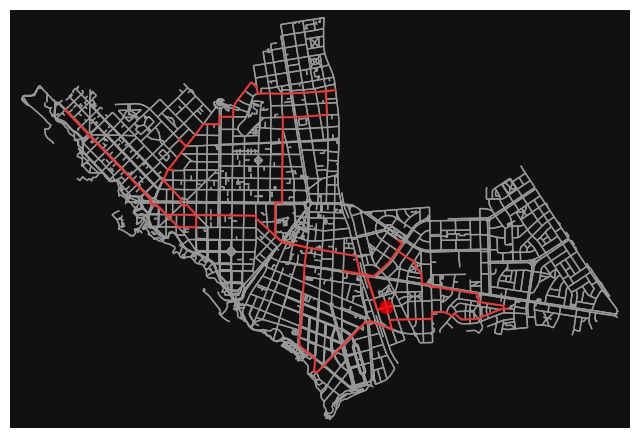

In [32]:
# Construir la ruta completa paso a paso
ruta_completa = []
for u, v in zip(ruta[:-1], ruta[1:]):
    try:
        path = nx.shortest_path(G, u, v, weight='length')
        ruta_completa.extend(path[:-1])  # Excluir el último nodo para evitar duplicados
    except nx.NetworkXNoPath:
        print(f"No se encontró un camino entre {u} y {v}")
ruta_completa.append(ruta[-1])  # Agregar el último nodo

# Visualizar la ruta completa en el grafo
fig, ax = ox.plot_graph_route(G, route=ruta_completa, route_linewidth=2, node_size=0)
plt.show()

### Algoritmo Nro. 1
#### Búsqueda en Profundidad (Depth-First Search)

##### Celda 8.1: Definir la función DFS

In [ ]:
# Crear función DFS para recorrer todas las iglesias
def dfs(grafo, nodo_inicial):
    visitados = set()
    stack = [nodo_inicial]
    recorrido = []
    while stack:
        nodo = stack.pop()
        if nodo not in visitados:
            visitados.add(nodo)
            recorrido.append(nodo)
            for vecino in grafo[nodo]:
                if vecino not in visitados:
                    stack.append(vecino)
    return recorrido


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Celda 8.2: Crear lista de adyacencia para el grafo procesado

In [ ]:
# Crear lista de adyacencia para el grafo procesado
lista_adyacencia_dfs = {nodo: set() for nodo in iglesias_nodos}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        lista_adyacencia_dfs[u].add(v)
        lista_adyacencia_dfs[v].add(u)
    except nx.NetworkXNoPath:
        continue

##### Celda 8.3: Inicializar variables para guardar el mejor resultado

In [ ]:
# Inicializar variables para guardar el mejor resultado
mejor_ruta = None
menor_distancia = float('inf')
mejor_nodo_inicial = None

##### Celda 8.4: Probar cada nodo como nodo inicial y realizar el recorrido DFS

In [ ]:
# Probar cada nodo como nodo inicial
for nodo_inicial_dfs in iglesias_nodos:
    # Realizar el recorrido DFS
    ruta_dfs = dfs(lista_adyacencia_dfs, nodo_inicial_dfs)

    # Calcular la distancia total recorrida en el recorrido DFS
    distancia_total_dfs = 0
    for u, v in zip(ruta_dfs[:-1], ruta_dfs[1:]):
        try:
            distancia_total_dfs += nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        except nx.NetworkXNoPath:
            continue

    # Si la distancia total de esta ruta es menor que la mejor encontrada hasta ahora, actualizar
    if distancia_total_dfs < menor_distancia:
        mejor_ruta = ruta_dfs
        menor_distancia = distancia_total_dfs
        mejor_nodo_inicial = nodo_inicial_dfs

##### Celda 8.5: Visualizar la mejor ruta DFS en el grafo

Mejor nodo inicial: 262725526
Mejor ruta DFS del feligrés: [262725526, 262571000, 114615160, 262570611, 108237811, 4266659697, 257946723, 10800984803, 263617506, 138854739, 262572744, 4332504766, 262578746, 263636652, 386837776, 197660043, 138851464, 6083786756, 1760085377, 6122446208]
Distancia total recorrida con DFS: 35096.18 metros


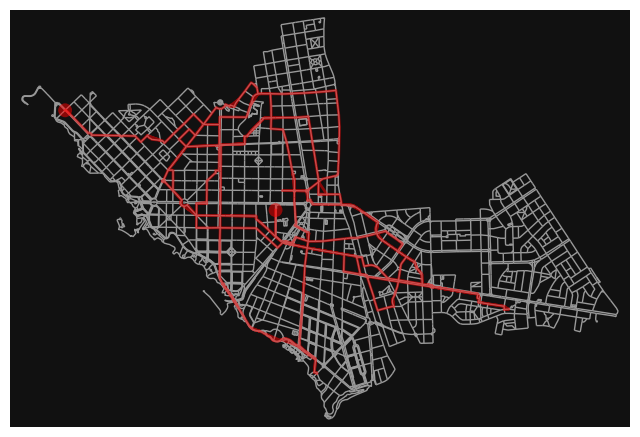

In [ ]:
# Visualizar la mejor ruta DFS en el grafo
ruta_completa_dfs = []
for u, v in zip(mejor_ruta[:-1], mejor_ruta[1:]):
    try:
        path = nx.shortest_path(G_no_dirigido, u, v, weight='length')
        ruta_completa_dfs.extend(path[:-1])  # Excluir el último nodo para evitar duplicados
    except nx.NetworkXNoPath:
        print(f"No se encontró un camino entre {u} y {v}")
ruta_completa_dfs.append(mejor_ruta[-1])  # Agregar el último nodo

# Mostrar la mejor ruta DFS y la distancia total
print("Mejor nodo inicial:", mejor_nodo_inicial)
print("Mejor ruta DFS del feligrés:", mejor_ruta)
print(f"Distancia total recorrida con DFS: {menor_distancia:.2f} metros")

# Visualizar la ruta completa en el grafo
fig, ax = ox.plot_graph_route(G_no_dirigido, route=ruta_completa_dfs, route_linewidth=2, node_size=0)
plt.show()

##### Celda 8.6: Calcular la medida de racionalidad promedio

In [ ]:
import random

def calcular_racionalidad_promedio(grafo, lista_adyacencia, nodos_interes, distancia_optima, iteraciones=10):
    sum_racionalidad = 0

    for _ in range(iteraciones):
        # Nodo inicial aleatorio
        nodo_inicial_aleatorio = random.choice(nodos_interes)

        # Realizar el recorrido DFS desde el nodo inicial aleatorio
        ruta_dfs_aleatoria = dfs(lista_adyacencia, nodo_inicial_aleatorio)

        distancia_total_dfs_aleatoria = 0
        for u, v in zip(ruta_dfs_aleatoria[:-1], ruta_dfs_aleatoria[1:]):
            try:
                distancia_total_dfs_aleatoria += nx.shortest_path_length(grafo, u, v, weight='length')
            except nx.NetworkXNoPath:
                continue

        # Medida de racionalidad para esta iteración
        racionalidad_dfs = distancia_total_dfs_aleatoria / distancia_optima
        sum_racionalidad += racionalidad_dfs

    # Medida de racionalidad promedio
    racionalidad_promedio = sum_racionalidad / iteraciones
    return racionalidad_promedio

distancia_optima = 18050.39
iteraciones = 10

racionalidad_promedio_dfs = calcular_racionalidad_promedio(G_no_dirigido, lista_adyacencia_dfs, iglesias_nodos, distancia_optima, iteraciones)

# Mostrar el resultado
print(f"Medida de Racionalidad Promedio del Algoritmo DFS (en {iteraciones} iteraciones): {racionalidad_promedio_dfs:.2f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Medida de Racionalidad Promedio del Algoritmo DFS (en 10 iteraciones): 2.20


### Algoritmo Nro. 2
#### Búsqueda en Amplitud (Breadth-First Search)

##### Celda 9.1: Definir la función BFS

In [ ]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from itertools import combinations

# Crear función BFS para recorrer todas las iglesias
def bfs(grafo, nodo_inicial):
    visitados = set()
    queue = [nodo_inicial]
    recorrido = []
    while queue:
        nodo = queue.pop(0)
        if nodo not in visitados:
            visitados.add(nodo)
            recorrido.append(nodo)
            for vecino in grafo[nodo]:
                if vecino not in visitados:
                    queue.append(vecino)
    return recorrido


##### Celda 9.2: Crear lista de adyacencia para el grafo procesado

In [ ]:
# Crear lista de adyacencia para el grafo procesado
lista_adyacencia_bfs = {nodo: set() for nodo in iglesias_nodos}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        lista_adyacencia_bfs[u].add(v)
        lista_adyacencia_bfs[v].add(u)
    except nx.NetworkXNoPath:
        continue

##### Celda 9.3: Inicializar variables para guardar el mejor resultado

In [ ]:
# Inicializar variables para guardar el mejor resultado
mejor_ruta = None
menor_distancia = float('inf')
mejor_nodo_inicial = None

##### Celda 9.4: Probar cada nodo como nodo inicial y realizar el recorrido BFS

In [ ]:
# Probar cada nodo como nodo inicial
for nodo_inicial_bfs in iglesias_nodos:
    # Realizar el recorrido BFS
    ruta_bfs = bfs(lista_adyacencia_bfs, nodo_inicial_bfs)

    # Calcular la distancia total recorrida en el recorrido BFS
    distancia_total_bfs = 0
    for u, v in zip(ruta_bfs[:-1], ruta_bfs[1:]):
        try:
            distancia_total_bfs += nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        except nx.NetworkXNoPath:
            continue

    # Si la distancia total de esta ruta es menor que la mejor encontrada hasta ahora, actualizar
    if distancia_total_bfs < menor_distancia:
        mejor_ruta = ruta_bfs
        menor_distancia = distancia_total_bfs
        mejor_nodo_inicial = nodo_inicial_bfs

##### Celda 9.5: Visualizar la mejor ruta BFS en el grafo

Mejor nodo inicial: 262725526
Mejor ruta BFS del feligrés: [262725526, 6122446208, 1760085377, 6083786756, 138851464, 197660043, 386837776, 263636652, 262578746, 4332504766, 262572744, 138854739, 263617506, 10800984803, 257946723, 4266659697, 108237811, 262570611, 114615160, 262571000]
Distancia total recorrida con BFS: 35757.46 metros


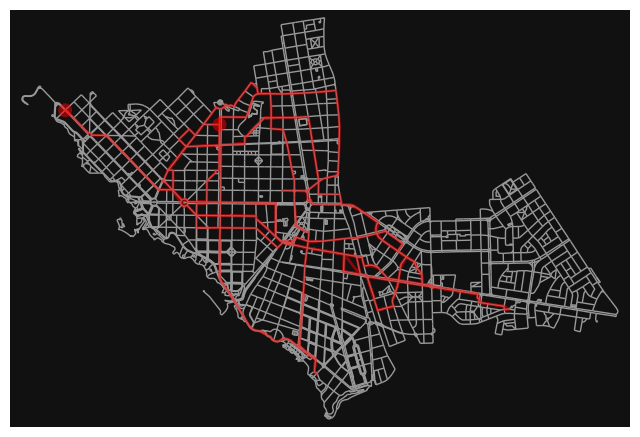

In [ ]:
# Visualizar la mejor ruta BFS en el grafo
ruta_completa_bfs = []
for u, v in zip(mejor_ruta[:-1], mejor_ruta[1:]):
    try:
        path = nx.shortest_path(G_no_dirigido, u, v, weight='length')
        ruta_completa_bfs.extend(path[:-1])  # Excluir el último nodo para evitar duplicados
    except nx.NetworkXNoPath:
        print(f"No se encontró un camino entre {u} y {v}")
ruta_completa_bfs.append(mejor_ruta[-1])  # Agregar el último nodo

# Mostrar la mejor ruta BFS y la distancia total
print("Mejor nodo inicial:", mejor_nodo_inicial)
print("Mejor ruta BFS del feligrés:", mejor_ruta)
print(f"Distancia total recorrida con BFS: {menor_distancia:.2f} metros")

# Visualizar la ruta completa en el grafo
fig, ax = ox.plot_graph_route(G_no_dirigido, route=ruta_completa_bfs, route_linewidth=2, node_size=0)
plt.show()

##### Celda 9.6: Calcular la medida de racionalidad promedio

In [ ]:
import random

def calcular_racionalidad_promedio_bfs(grafo, lista_adyacencia, nodos_interes, distancia_optima, iteraciones=10):
    sum_racionalidad = 0

    for _ in range(iteraciones):
        # Nodo inicial aleatorio
        nodo_inicial_aleatorio = random.choice(nodos_interes)

        # Realizar el recorrido BFS desde el nodo inicial aleatorio
        ruta_bfs_aleatoria = bfs(lista_adyacencia, nodo_inicial_aleatorio)

        # Calcular la distancia total recorrida en el recorrido BFS aleatorio
        distancia_total_bfs_aleatoria = 0
        for u, v in zip(ruta_bfs_aleatoria[:-1], ruta_bfs_aleatoria[1:]):
            try:
                distancia_total_bfs_aleatoria += nx.shortest_path_length(grafo, u, v, weight='length')
            except nx.NetworkXNoPath:
                continue

        # Calcular la medida de racionalidad para esta iteración
        racionalidad_bfs = distancia_total_bfs_aleatoria / distancia_optima
        sum_racionalidad += racionalidad_bfs

    # Calcular la medida de racionalidad promedio
    racionalidad_promedio = sum_racionalidad / iteraciones
    return racionalidad_promedio

# Distancia óptima conocida (sustituir con el valor correcto)
distancia_optima = 18050.39

# Número de iteraciones
iteraciones = 10

# Calcular la medida de racionalidad promedio
racionalidad_promedio_bfs = calcular_racionalidad_promedio_bfs(G_no_dirigido, lista_adyacencia_bfs, iglesias_nodos, distancia_optima, iteraciones)

# Mostrar el resultado
print(f"Medida de Racionalidad Promedio del Algoritmo BFS (en {iteraciones} iteraciones): {racionalidad_promedio_bfs:.2f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Medida de Racionalidad Promedio del Algoritmo BFS (en 10 iteraciones): 2.13


### Algoritmo Nro. 3
#### Búsqueda en Voraz (Greedy Best-First Search)

##### Celda 10.1: Definir la función para encontrar el nodo más cercano

In [ ]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from itertools import combinations

# Función para encontrar el nodo más cercano
def encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia):
    min_dist = float('inf')
    nodo_mas_cercano = None
    for nodo in nodos_restantes:
        if nodo in lista_adyacencia[nodo_actual]:
            dist = lista_adyacencia[nodo_actual][nodo]
            if dist < min_dist:
                min_dist = dist
                nodo_mas_cercano = nodo
    return nodo_mas_cercano, min_dist

##### Celda 10.2: Crear lista de adyacencia

In [ ]:
# Crear lista de adyacencia
lista_adyacencia = {nodo: {} for nodo in iglesias_nodos}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        lista_adyacencia[u][v] = length
        lista_adyacencia[v][u] = length
    except nx.NetworkXNoPath:
        continue

##### Celda 10.3: Inicializar variables para guardar el mejor resultado

In [ ]:
  # Inicializar variables para guardar el mejor resultado
mejor_ruta = None
menor_distancia = float('inf')
mejor_nodo_inicial = None

##### Celda 10.4: Probar cada nodo como nodo inicial y realizar el recorrido con Búsqueda Voraz


In [ ]:
# Probar cada nodo como nodo inicial
for nodo_inicial_greedy in iglesias_nodos:
    # Inicializar variables para el recorrido
    nodo_actual = nodo_inicial_greedy
    nodos_restantes = set(iglesias_nodos)
    nodos_restantes.remove(nodo_actual)
    ruta = [nodo_actual]
    distancia_total = 0

    # Recorrer todas las iglesias usando el método del vecino más cercano
    while nodos_restantes:
        nodo_mas_cercano, min_dist = encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia)
        if nodo_mas_cercano is None:
            break
        ruta.append(nodo_mas_cercano)
        distancia_total += min_dist
        nodo_actual = nodo_mas_cercano
        nodos_restantes.remove(nodo_actual)

    # Si la distancia total de esta ruta es menor que la mejor encontrada hasta ahora, actualizar
    if distancia_total < menor_distancia:
        mejor_ruta = ruta
        menor_distancia = distancia_total
        mejor_nodo_inicial = nodo_inicial_greedy

##### Celda 10.5: Visualizar la mejor ruta de Búsqueda Voraz en el grafo

Mejor nodo inicial: 114615160
Mejor ruta de Búsqueda Voraz del feligrés: [114615160, 1760085377, 263636652, 386837776, 263617506, 6083786756, 6122446208, 138854739, 257946723, 138851464, 262572744, 262570611, 262571000, 4266659697, 4332504766, 108237811, 262578746, 10800984803, 197660043, 262725526]
Distancia total recorrida con Búsqueda Voraz: 13653.34 metros


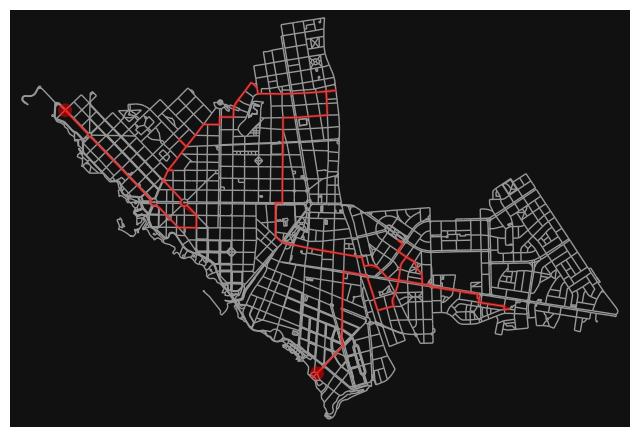

In [ ]:
# Visualizar la mejor ruta de Búsqueda Voraz en el grafo
ruta_completa_greedy = []
for u, v in zip(mejor_ruta[:-1], mejor_ruta[1:]):
    try:
        path = nx.shortest_path(G_no_dirigido, u, v, weight='length')
        ruta_completa_greedy.extend(path[:-1])  # Excluir el último nodo para evitar duplicados
    except nx.NetworkXNoPath:
        print(f"No se encontró un camino entre {u} y {v}")
ruta_completa_greedy.append(mejor_ruta[-1])  # Agregar el último nodo

# Mostrar la mejor ruta de Búsqueda Voraz y la distancia total
print("Mejor nodo inicial:", mejor_nodo_inicial)
print("Mejor ruta de Búsqueda Voraz del feligrés:", mejor_ruta)
print(f"Distancia total recorrida con Búsqueda Voraz: {menor_distancia:.2f} metros")

# Visualizar la ruta completa en el grafo
fig, ax = ox.plot_graph_route(G_no_dirigido, route=ruta_completa_greedy, route_linewidth=2, node_size=0)
plt.show()

##### Celda 10.6: Calcular la medida de racionalidad promedio

In [ ]:
import random

def calcular_racionalidad_promedio_greedy(grafo, lista_adyacencia, nodos_interes, distancia_optima, iteraciones=10):
    sum_racionalidad = 0

    for _ in range(iteraciones):
        # Nodo inicial aleatorio
        nodo_inicial_aleatorio = random.choice(nodos_interes)

        # Inicializar variables para el recorrido
        nodo_actual = nodo_inicial_aleatorio
        nodos_restantes = set(nodos_interes)
        nodos_restantes.remove(nodo_actual)
        ruta = [nodo_actual]
        distancia_total = 0

        # Recorrer todas las iglesias usando el método del vecino más cercano
        while nodos_restantes:
            nodo_mas_cercano, min_dist = encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia)
            if nodo_mas_cercano is None:
                break
            ruta.append(nodo_mas_cercano)
            distancia_total += min_dist
            nodo_actual = nodo_mas_cercano
            nodos_restantes.remove(nodo_actual)

        # Calcular la medida de racionalidad para esta iteración
        racionalidad_greedy = distancia_total / distancia_optima
        sum_racionalidad += racionalidad_greedy

    # Calcular la medida de racionalidad promedio
    racionalidad_promedio = sum_racionalidad / iteraciones
    return racionalidad_promedio

# Distancia óptima conocida (sustituir con el valor correcto)
distancia_optima = 18050.39

# Número de iteraciones
iteraciones = 10

# Calcular la medida de racionalidad promedio
racionalidad_promedio_greedy = calcular_racionalidad_promedio_greedy(G_no_dirigido, lista_adyacencia, iglesias_nodos, distancia_optima, iteraciones)

# Mostrar el resultado
print(f"Medida de Racionalidad Promedio del Algoritmo Greedy (en {iteraciones} iteraciones): {racionalidad_promedio_greedy:.2f}")


Medida de Racionalidad Promedio del Algoritmo Greedy (en 10 iteraciones): 0.84


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Algoritmo Nro. 4
#### A* (A-Star)

##### Celda 11.1: Definir la función para encontrar el nodo más cercano

In [33]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from itertools import combinations

# Función para encontrar el nodo más cercano
def encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia):
    min_dist = float('inf')
    nodo_mas_cercano = None
    for nodo in nodos_restantes:
        if nodo in lista_adyacencia[nodo_actual]:
            dist = lista_adyacencia[nodo_actual][nodo]
            if dist < min_dist:
                min_dist = dist
                nodo_mas_cercano = nodo
    return nodo_mas_cercano, min_dist

##### Celda 11.2: Crear lista de adyacencia

In [34]:
# Crear lista de adyacencia
lista_adyacencia = {nodo: {} for nodo in iglesias_nodos}
for u, v in combinations(iglesias_nodos, 2):
    try:
        length = nx.shortest_path_length(G_no_dirigido, u, v, weight='length')
        lista_adyacencia[u][v] = length
        lista_adyacencia[v][u] = length
    except nx.NetworkXNoPath:
        continue

##### Celda 11.3: Inicializar variables para guardar el mejor resultado

In [35]:
# Inicializar variables para guardar el mejor resultado
mejor_ruta = None
menor_distancia = float('inf')
mejor_nodo_inicial = None

##### Celda 11.4: Probar cada nodo como nodo inicial y realizar el recorrido con A*

In [36]:
# Probar cada nodo como nodo inicial
for nodo_inicial_a_star in iglesias_nodos:
    # Inicializar variables para el recorrido
    nodo_actual = nodo_inicial_a_star
    nodos_restantes = set(iglesias_nodos)
    nodos_restantes.remove(nodo_actual)
    ruta = [nodo_actual]
    distancia_total = 0

    # Recorrer todas las iglesias usando el método del vecino más cercano
    while nodos_restantes:
        nodo_mas_cercano, min_dist = encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia)
        if nodo_mas_cercano is None:
            break
        ruta.append(nodo_mas_cercano)
        distancia_total += min_dist
        nodo_actual = nodo_mas_cercano
        nodos_restantes.remove(nodo_actual)

    # Si la distancia total de esta ruta es menor que la mejor encontrada hasta ahora, actualizar
    if distancia_total < menor_distancia:
        mejor_ruta = ruta
        menor_distancia = distancia_total
        mejor_nodo_inicial = nodo_inicial_a_star

##### Celda 11.5: Visualizar la mejor ruta A* en el grafo

Mejor nodo inicial: 114615160
Mejor ruta A* del feligrés: [114615160, 1760085377, 263636652, 386837776, 263617506, 6083786756, 6122446208, 138854739, 257946723, 138851464, 262572744, 262570611, 262571000, 4266659697, 4332504766, 108237811, 262578746, 10800984803, 197660043, 262725526]
Distancia total recorrida con A*: 13653.34 metros


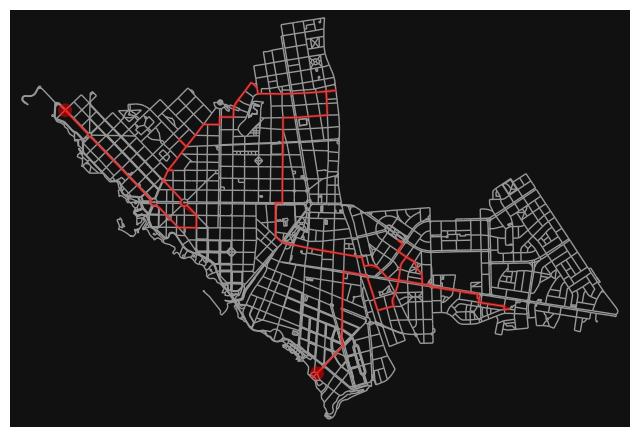

In [37]:
# Visualizar la mejor ruta A* en el grafo
ruta_completa_a_star = []
for u, v in zip(mejor_ruta[:-1], mejor_ruta[1:]):
    try:
        path = nx.shortest_path(G_no_dirigido, u, v, weight='length')
        ruta_completa_a_star.extend(path[:-1])  # Excluir el último nodo para evitar duplicados
    except nx.NetworkXNoPath:
        print(f"No se encontró un camino entre {u} y {v}")
ruta_completa_a_star.append(mejor_ruta[-1])  # Agregar el último nodo

# Mostrar la mejor ruta A* y la distancia total
print("Mejor nodo inicial:", mejor_nodo_inicial)
print("Mejor ruta A* del feligrés:", mejor_ruta)
print(f"Distancia total recorrida con A*: {menor_distancia:.2f} metros")

# Visualizar la ruta completa en el grafo
fig, ax = ox.plot_graph_route(G_no_dirigido, route=ruta_completa_a_star, route_linewidth=2, node_size=0)
plt.show()


##### Celda 11.6: Calcular la medida de racionalidad promedio

In [39]:
import random

def calcular_racionalidad_promedio_a_star(grafo, lista_adyacencia, nodos_interes, distancia_optima, iteraciones=10):
    sum_racionalidad = 0

    for _ in range(iteraciones):
        # Nodo inicial aleatorio
        nodo_inicial_aleatorio = random.choice(nodos_interes)

        # Inicializar variables para el recorrido
        nodo_actual = nodo_inicial_aleatorio
        nodos_restantes = set(nodos_interes)
        nodos_restantes.remove(nodo_actual)
        ruta = [nodo_actual]
        distancia_total = 0

        # Recorrer todas las iglesias usando el método del vecino más cercano
        while nodos_restantes:
            nodo_mas_cercano, min_dist = encontrar_mas_cercano(nodo_actual, nodos_restantes, lista_adyacencia)
            if nodo_mas_cercano is None:
                break
            ruta.append(nodo_mas_cercano)
            distancia_total += min_dist
            nodo_actual = nodo_mas_cercano
            nodos_restantes.remove(nodo_actual)

        # Calcular la medida de racionalidad para esta iteración
        racionalidad_a_star = distancia_total / distancia_optima
        sum_racionalidad += racionalidad_a_star

    # Calcular la medida de racionalidad promedio
    racionalidad_promedio = sum_racionalidad / iteraciones
    return racionalidad_promedio

# Distancia óptima conocida (sustituir con el valor correcto)
distancia_optima = 18050.39

# Número de iteraciones
iteraciones = 10

# Calcular la medida de racionalidad promedio
racionalidad_promedio_a_star = calcular_racionalidad_promedio_a_star(G_no_dirigido, lista_adyacencia, iglesias_nodos, distancia_optima, iteraciones)

# Mostrar el resultado
print(f"Medida de Racionalidad Promedio del Algoritmo A* (en {iteraciones} iteraciones): {racionalidad_promedio_a_star:.2f}")


Medida de Racionalidad Promedio del Algoritmo A* (en 10 iteraciones): 0.87


### Algoritmo Nro. 5
#### Coste Uniforme

##### Celda 12.1: Definir el lugar y descargar el grafo

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic
import heapq
import time
import random

# Definir el lugar
place_name = "Miraflores, Lima, Peru"

# Descargar el grafo de calles de Miraflores
G = ox.graph_from_place(place_name, network_type="drive")


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


##### Celda 12.2: Convertir a grafo no dirigido y preprocesamiento

In [ ]:
# Convertir a grafo no dirigido para el preprocesamiento
G_no_dirigido = G.to_undirected()

# Eliminar nodos aislados y calles sin salida
isolated_nodes = list(nx.isolates(G_no_dirigido))
dead_ends = [node for node, degree in dict(G_no_dirigido.degree()).items() if degree == 1]
G_no_dirigido.remove_nodes_from(isolated_nodes + dead_ends)

# Mantener solo el componente conectado más grande
largest_cc = max(nx.connected_components(G_no_dirigido), key=len)
G_no_dirigido = G_no_dirigido.subgraph(largest_cc).copy()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Celda 12.3: Almacenar lugares de interés (iglesias)

In [ ]:
# Almacenar lugares de interés (iglesias)
tags = {'amenity': 'place_of_worship', 'religion': 'christian'}
points = ox.features_from_place(place_name, tags)

# Convertir polígonos a puntos usando el centroide
points['geometry'] = points.apply(
    lambda row: row['geometry'].centroid if row['geometry'].geom_type == 'Polygon' else row['geometry'],
    axis=1
)

# Filtrar solo los puntos que están dentro de los límites del grafo
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_no_dirigido)
graph_bounds = gdf_nodes.unary_union.bounds
points = points.cx[graph_bounds[0]:graph_bounds[2], graph_bounds[1]:graph_bounds[3]]

# Lista de nodos correspondientes a iglesias
iglesias_nodos = ox.distance.nearest_nodes(G_no_dirigido, points.geometry.x, points.geometry.y)

##### Celda 12.4: Convertir grafo a dirigido y añadir longitudes a las aristas

In [ ]:
# Convertir G_no_dirigido a dirigido para el algoritmo de búsqueda
G = G_no_dirigido.to_directed()

# Añadir longitudes a las aristas
def add_edge_lengths(G):
    for u, v, k, data in G.edges(keys=True, data=True):
        start = (G.nodes[u]['y'], G.nodes[u]['x'])
        end = (G.nodes[v]['y'], G.nodes[v]['x'])
        data['length'] = geodesic(start, end).meters
    return G

G = add_edge_lengths(G)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Celda 12.5: Definir funciones para calcular distancias y búsqueda de costo uniforme

In [ ]:
def calculate_path_distance(G, path):
    total_distance = 0
    for u, v in zip(path[:-1], path[1:]):
        total_distance += G.edges[u, v, 0]['length']
    return total_distance

# Implementación de Búsqueda de costo uniforme (Uniform Cost Search)
def uniform_cost_search(G, start, goals):
    open_set = [(0, start, [start])]
    closed_set = set()
    goals = set(goals)

    while open_set and goals:
        cost, current, path = heapq.heappop(open_set)

        if current in closed_set:
            continue

        if current in goals:
            goals.remove(current)
            if not goals:
                return path, cost
            closed_set = set()
            open_set = [(cost, current, path)]
            continue

        closed_set.add(current)

        for neighbor in G.neighbors(current):
            if neighbor not in closed_set:
                edge_cost = G.edges[current, neighbor, 0]['length']
                new_cost = cost + edge_cost
                new_path = path + [neighbor]
                heapq.heappush(open_set, (new_cost, neighbor, new_path))

    return None, float('inf')

##### Celda 12.6: Función para encontrar la mejor ruta

In [ ]:
# Función para encontrar la mejor ruta
def find_best_route(G, iglesias_nodos):
    best_path = None
    best_cost = float('inf')
    best_start = None

    for start_node in iglesias_nodos:
        path, cost = uniform_cost_search(G, start_node, set(iglesias_nodos) - {start_node})
        if path and cost < best_cost:
            best_path = path
            best_cost = cost
            best_start = start_node

    return best_path, best_cost, best_start

##### 12.7: Experimentación y análisis de resultados


In [ ]:
# Experimentación y análisis de resultados
start_time = time.time()

# Ejecutar el agente de búsqueda
best_path, best_cost, best_start = find_best_route(G, iglesias_nodos)

end_time = time.time()
computation_time = end_time - start_time

if best_path:
    print(f"Mejor ruta encontrada (iniciando desde el nodo {best_start}):")
    print(best_path)
    print(f"Costo total (distancia): {best_cost:.2f} metros")
else:
    print("No se encontró una ruta que visite todas las iglesias")

Mejor ruta encontrada (iniciando desde el nodo 262725526):
[262725526, 262725525, 262725514, 262725511, 262725484, 262725483, 10748688662, 262725482, 262725376, 262724723, 1432446026, 259996516, 262725207, 259996515, 259996514, 262724828, 108237807, 108237808, 262578746, 108237808, 108237811, 837760898, 4266659697, 4266659695, 4332504766, 262726656, 108237813, 108237815, 262571001, 262571000, 4332539160, 262570744, 262570743, 262570899, 262570898, 262570656, 262570627, 262570611, 262570610, 3811342110, 262567627, 3811342111, 262567626, 257946751, 257946726, 257946723, 108180346, 108177591, 138851464, 262572419, 262572576, 262572575, 262572574, 262572744, 262572729, 262572630, 262572616, 262572801, 262574563, 262573104, 262575158, 262576416, 4081637707, 4081637710, 4081637716, 4081637704, 4081637702, 138851473, 138851471, 138854662, 108180356, 138854740, 138854739, 262577861, 3908702116, 262577864, 262577893, 262577875, 108193635, 133924945, 114613813, 133925753, 108178122, 108178124, 2

##### 12.8: Visualización de resultados

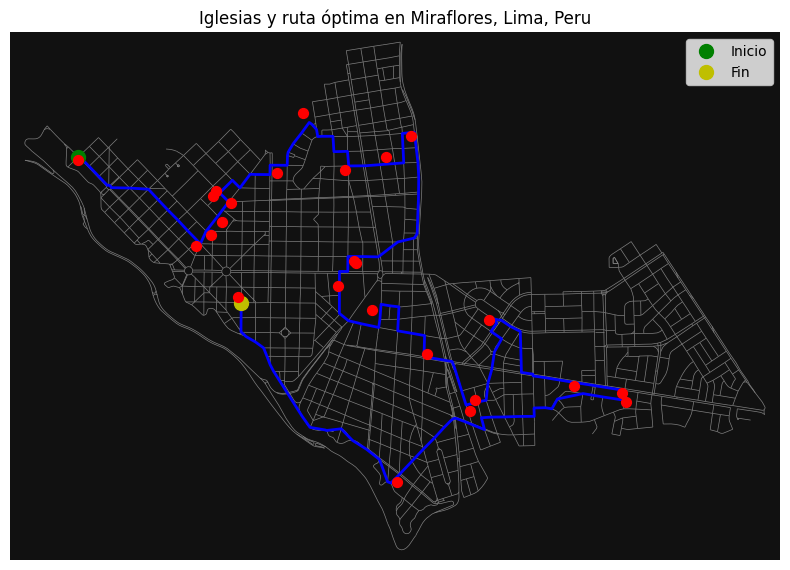

In [ ]:
# Visualización de resultados
fig, ax = ox.plot_graph(G_no_dirigido, show=False, close=False, edge_color='gray', edge_linewidth=0.5, node_size=0)

# Plotear las iglesias
points.plot(ax=ax, color='red', markersize=50, zorder=3)

# Plotear la ruta encontrada
if best_path:
    route_coords = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in best_path]
    route_x, route_y = zip(*route_coords)
    ax.plot(route_x, route_y, color='blue', linewidth=2, zorder=2)

    # Marcar el inicio y fin de la ruta
    ax.plot(route_x[0], route_y[0], 'go', markersize=10, label='Inicio')
    ax.plot(route_x[-1], route_y[-1], 'yo', markersize=10, label='Fin')

plt.title(f"Iglesias y ruta óptima en {place_name}")
plt.legend()
plt.tight_layout()
plt.show()

##### Celda 12.9: Calcular la medida de racionalidad promedio

In [ ]:
def calcular_racionalidad_promedio_uniform_cost(G, iglesias_nodos, distancia_optima, iteraciones=10):
    sum_racionalidad = 0

    for _ in range(iteraciones):
        # Nodo inicial aleatorio
        nodo_inicial_aleatorio = random.choice(iglesias_nodos)

        # Ejecutar el agente de búsqueda
        path, cost = uniform_cost_search(G, nodo_inicial_aleatorio, set(iglesias_nodos) - {nodo_inicial_aleatorio})

        # Si se encontró una ruta válida, calcular la medida de racionalidad
        if path:
            racionalidad = cost / distancia_optima
            sum_racionalidad += racionalidad

    # Calcular la medida de racionalidad promedio
    racionalidad_promedio = sum_racionalidad / iteraciones
    return racionalidad_promedio

# Distancia óptima conocida (sustituir con el valor correcto)
distancia_optima = 18050.39

# Número de iteraciones
iteraciones = 10

# Calcular la medida de racionalidad promedio
racionalidad_promedio_uniform_cost = calcular_racionalidad_promedio_uniform_cost(G, iglesias_nodos, distancia_optima, iteraciones)

# Mostrar el resultado
print(f"Medida de Racionalidad Promedio del Algoritmo de Costo Uniforme (en {iteraciones} iteraciones): {racionalidad_promedio_uniform_cost:.2f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Medida de Racionalidad Promedio del Algoritmo de Costo Uniforme (en 10 iteraciones): 0.90
